# Data distribution over the years

# Import Modules

In [1]:
import os
import string
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from utils import find_multipatent_compounds

tqdm.pandas()

# Add path constants

In [2]:
FIG_DIR = "../data/figures"
DATA_DIR = "../data/raw"
os.makedirs(FIG_DIR, exist_ok=True)

# Load data file

In [3]:
surechembl_df = pd.read_parquet(f"{DATA_DIR}/surechembl_dump.pq")
surechembl_df.head(2)

,SureChEMBL_ID,SMILES,InChIKey,PATENT_ID,PUBLICATION_DATE,Field
0,SCHEMBL4,C[C@H](CS)C(=O)N1CCC[C@H]1C(O)=O,FAKRSMQSSFJEIM-RQJHMYQMSA-N,EP-2842582-A2,2015-03-04,Description
1,SCHEMBL4,C[C@H](CS)C(=O)N1CCC[C@H]1C(O)=O,FAKRSMQSSFJEIM-RQJHMYQMSA-N,EP-2838373-A2,2015-02-25,Description


In [4]:
# Extract year from publication date
surechembl_df["year"] = surechembl_df["PUBLICATION_DATE"].progress_apply(
    lambda x: x.split("-")[0]
)

100%|██████████| 133512452/133512452 [00:50<00:00, 2626731.97it/s]


In [5]:
surechembl_df["SureChEMBL_ID"].nunique(), surechembl_df["PATENT_ID"].nunique()

(10718652, 1574602)

In [6]:
surechembl_df["SMILES"].nunique(), surechembl_df["InChIKey"].nunique()

(10718647, 10686744)

Since InchiKey is the most repliable compound representation, we choose that for finding overlaps between the datasets

# Filtering duplicate patent IDs

In [7]:
unique_patent_df = surechembl_df.drop_duplicates(
    subset=["PATENT_ID", "year"], keep="first"
)
unique_patent_df.shape

(1574604, 7)

In [8]:
# Calculate unique patents per year
patent_count_df = pd.DataFrame(unique_patent_df["year"].value_counts()).reset_index()
patent_count_df.columns = ["year", "patent_count"]
patent_count_df.sort_values("year", ascending=True, inplace=True)
patent_count_df

,year,patent_count
6,2015,188598
4,2016,200056
3,2017,203123
2,2018,207456
5,2019,194261
1,2020,220631
0,2021,222474
7,2022,138005


In [9]:
patent_count_df["patent_count"].mean()

196825.5

About 196,825 patents are filed every year.

# Calculate unique compounds per year

In [10]:
# Get repreated smile counts
compound_count_df = find_multipatent_compounds(surechembl_df)
compound_count_df["unique_compounds"].mean()

1137183.4285714286

In [11]:
# the total no.of unique compounds
compound_count_df["patented_drug_count"].mean() / compound_count_df[
    "unique_compounds"
].sum()

0.20046809887687425

0.2% compounds were found to be found to be linked with multiple patents.

In [12]:
compound_count_df

,year,patented_drug_count,unique_compounds
0,2016,1298420,1545252
1,2017,1818745,1530677
2,2018,1695482,871159
3,2019,1653234,977705
4,2020,1722031,1193276
5,2021,1779891,1220263
6,2022,1202678,621952


# Cumulative unique patent counts

In [13]:
cummulative_counts = []

for year in tqdm(surechembl_df["year"].unique()):
    t = surechembl_df[surechembl_df["year"] <= year]
    cummulative_counts.append(
        {
            "year": year,
            "unique_compounds": t["InChIKey"].nunique(),
        }
    )

cummulative_counts_df = pd.DataFrame(cummulative_counts)
cummulative_counts_df

100%|██████████| 8/8 [03:52<00:00, 29.09s/it]


,year,unique_compounds
0,2015,2726460
1,2016,4271712
2,2017,5802389
3,2018,6673548
4,2019,7651253
5,2020,8844529
6,2021,10064792
7,2022,10686744


# Patent kind code distribution
Here the values have been translated from original counts into percentages for sake of representation.

In [14]:
# Generated custom from data
patent_type_counts = {
    "EP": {"A": 45.5, "B": 54.5},
    "JP": {"A": 48.65, "B": 1.35},
    "US": {
        "A": 80.6,
        "B": 67.7,
        "Other": 1.7,
    },
}

In [15]:
patent_type_counter_df = []

for i, j_dict in patent_type_counts.items():
    for j, k in j_dict.items():
        patent_type_counter_df.append({"country": i, "patent_type": j, "count": k})

patent_type_counter_df = pd.DataFrame(patent_type_counter_df)
k = patent_type_counter_df.pivot_table("count", ["country", "patent_type"])

# Visualisation

In [16]:
sns.set_style("whitegrid")

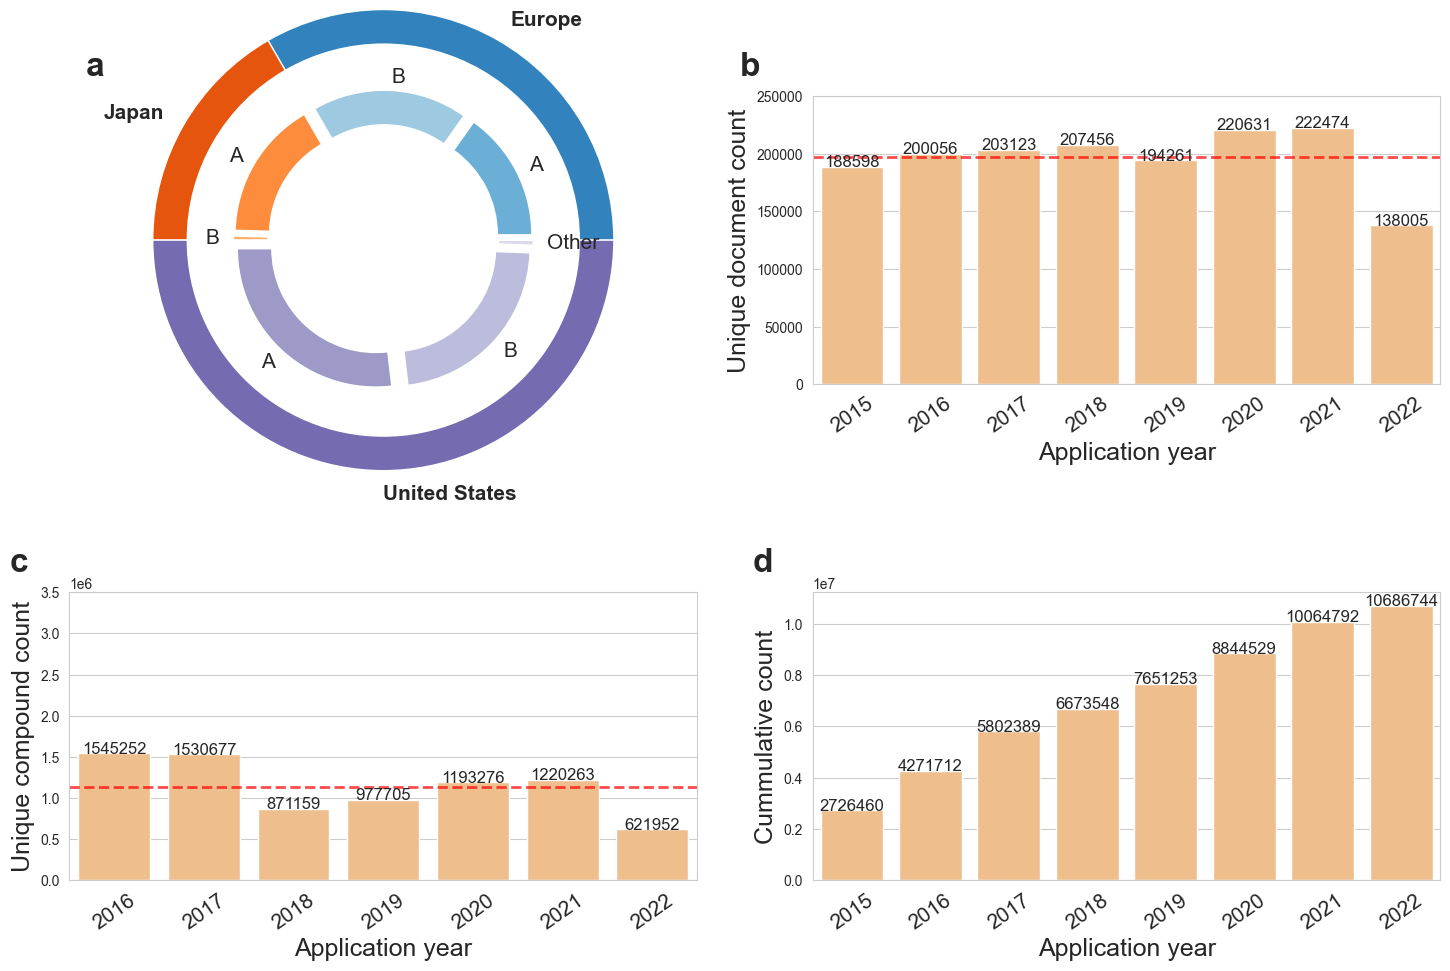

In [17]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
labels = ["Europe", "Japan", "United States"]
inner_labels = ["A", "B", "A", "B", "A", "B", "Other"]
vals = k["count"]
group_sum = k.groupby("country")["count"].sum()
patent_count_avg = patent_count_df["patent_count"].mean()

cmap = plt.colormaps["tab20c"]
outer_colors = cmap([0, 4, 12])
inner_colors = cmap([1, 2, 5, 6, 13, 14, 15])  # EP  # JP  # US

plt.pie(
    group_sum,
    radius=2,
    colors=outer_colors,
    labels=labels,
    textprops={"fontsize": 15, "fontweight": "bold"},
    wedgeprops=dict(width=0.3, edgecolor="w"),
)

plt.pie(
    vals,
    radius=1.5 - 0.3,
    colors=inner_colors,
    labels=inner_labels,
    textprops={"fontsize": 15},
    wedgeprops=dict(width=0.3, edgecolor="w"),
    explode=(0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1),
)

plt.text(
    -0.5,
    1.1,
    string.ascii_lowercase[0],
    size=24,
    weight="bold",
    horizontalalignment="center",
    verticalalignment="center",
    transform=plt.gca().transAxes,
)

plt.subplot(2, 2, 2)
ax1 = sns.barplot(data=patent_count_df, x="year", y="patent_count", color="#ffbe7d")
ax1.axhline(patent_count_avg, linewidth=2, color="r", linestyle="--", alpha=0.7)
plt.xlabel("Application year", fontsize=18)
plt.ylabel("Unique document count", fontsize=18)
plt.xticks(rotation=35, fontsize=15)
plt.ylim(top=250000)

# Show counts on top of plot
for p in ax1.patches:
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height() + 50
    value = int(p.get_height())
    ax1.text(_x, _y, value, ha="center", fontsize=12)

plt.text(
    -0.1,
    1.1,
    string.ascii_lowercase[1],
    size=24,
    weight="bold",
    horizontalalignment="center",
    verticalalignment="center",
    transform=plt.gca().transAxes,
)

cpds_count_avg = compound_count_df["unique_compounds"].mean()

plt.subplot(2, 2, 3)
ax2 = sns.barplot(
    data=compound_count_df, x="year", y="unique_compounds", color="#ffbe7d"
)
ax2.axhline(cpds_count_avg, linewidth=2, color="r", linestyle="--", alpha=0.7)
plt.xlabel("Application year", fontsize=18)
plt.ylabel("Unique compound count", fontsize=18)
plt.xticks(rotation=35, fontsize=15)
plt.ylim(top=3500000)

for p in ax2.patches:
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height() + 50
    value = int(p.get_height())
    ax2.text(_x, _y, value, ha="center", fontsize=12)

plt.text(
    -0.08,
    1.1,
    string.ascii_lowercase[2],
    size=24,
    weight="bold",
    horizontalalignment="center",
    verticalalignment="center",
    transform=plt.gca().transAxes,
)

plt.subplot(2, 2, 4)
ax2 = sns.barplot(
    data=cummulative_counts_df, x="year", y="unique_compounds", color="#ffbe7d"
)
plt.xlabel("Application year", fontsize=18)
plt.ylabel("Cummulative count", fontsize=18)
plt.xticks(rotation=35, fontsize=15)

for p in ax2.patches:
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height() + 50
    value = int(p.get_height())
    ax2.text(_x, _y, value, ha="center", fontsize=12)

plt.text(
    -0.08,
    1.1,
    string.ascii_lowercase[3],
    size=24,
    weight="bold",
    horizontalalignment="center",
    verticalalignment="center",
    transform=plt.gca().transAxes,
)

plt.tight_layout()
plt.savefig(f"{FIG_DIR}/figure_1.png", dpi=400)
plt.savefig(f"{FIG_DIR}/figure_1.pdf", dpi=400)
plt.show()

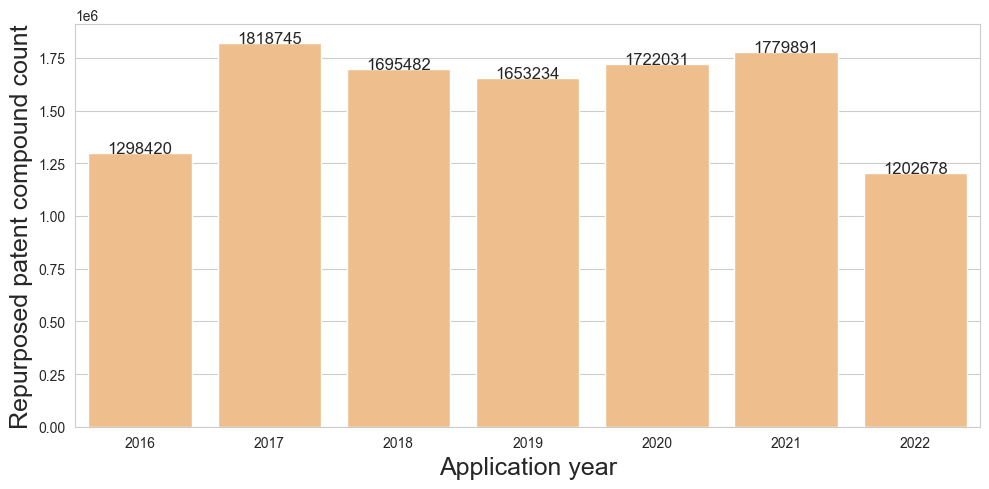

In [18]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(
    data=compound_count_df, x="year", y="patented_drug_count", color="#ffbe7d"
)

for p in ax.patches:
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height() + 50
    value = int(p.get_height())
    ax.text(_x, _y, value, ha="center", fontsize=12)

plt.xlabel("Application year", fontsize=18)
plt.ylabel("Repurposed patent compound count", fontsize=18)
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/figure_2.png", dpi=400)
plt.savefig(f"{FIG_DIR}/figure_2.pdf", dpi=400)
plt.show()